In [ ]:
# EMG data analysis by André Ivaniski-Mello
# andreivaniskimello@gmail.com

# 1) Import EMG data
# 2) Prepare data arrays
# 3) Filter curves
# 4) RMS
# 5) Temporal recort

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt
from scipy.signal import find_peaks
from scipy.signal import butter, lfilter
import ipywidgets as widgets
import tkinter as tk
from tkinter import simpledialog
from tkinter import Tk, simpledialog
import math
import csv
import scipy.io
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
from scipy.integrate import trapz

In [5]:
# Import Data
folder_path = "C:/Users/andre/Documents/Andre/Pesquisa/Projetos Pesquisa/Projeto Stefano/Routine/Data Test"

Array_Interpolated_Time_AllFiles = []
Array_iEMG_Interpolated_Time_AllFiles = []
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):  # Change the extension if needed
        file_path = os.path.join(folder_path, file_name)

        print('Now is reading the file:')
        print(file_name)
        df = pd.read_csv(file_path, delimiter =';', header = 2)
        #display(df)

        Array = np.array(df)

        # BAND PASS FILTER
        def butter_bandpass(lowcut, highcut, fs, order=5):
            nyquist = 0.5 * fs
            low = lowcut / nyquist
            high = highcut / nyquist
            b, a = butter(order, [low, high], btype='band')
            return b, a

        def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
            b, a = butter_bandpass(lowcut, highcut, fs, order=order)
            y = lfilter(b, a, data)
            return y

        # Design and apply the bandpass filter
        lowcut = 20  # Lower cutoff frequency
        highcut = 450  # Upper cutoff frequency
        order = 4  # Filter order
        fs = 2000

        Array_Filtered = np.array([butter_bandpass_filter(Array[:,m], lowcut, highcut, fs, order=order) for m in range(Array.shape[1])]).T

        
        
        # Band pass filter + RMS
        def rms_array(data, window_s, fsample):
            num_points = float(data.shape[0])

            # Calculate the square of each element in the data array
            squared_data = np.square(data)

            window_points = int(window_s * fsample)

            window_recorts = int(np.floor(num_points/window_points))

            rms = []
            for j in range(window_recorts-1):
                data_window = squared_data[window_points*j:window_points*(j+1)]
                data_window_sum_square = np.sum(data_window)
                data_window_mean_square = data_window_sum_square / window_points
                rms_window_iteration =  np.sqrt(data_window_mean_square)

                rms.append(rms_window_iteration)

            return rms

        window_s = 0.10 #in seconds
        fsample = 2000 #in Hertz
        Array_RMS = []
        for m in range(Array_Filtered.shape[1]):
            Array_Iteration = Array_Filtered[:,m]
            Array_RMS_Iteration = rms_array(Array_Iteration, window_s, fsample)
            Array_RMS_Iteration = np.array(Array_RMS_Iteration)
            Array_RMS.append(Array_RMS_Iteration)

        Array_RMS = np.array(Array_RMS).T
        
     
        # Band pass filter + RMS + Recort Baseline

        Baseline_seconds = 30 #in seconds
        Baseline_points = int(Baseline_seconds * fsample)

        Array_Baseline = []
        for m in range(Array_RMS.shape[1]):
            Array_Baseline_Iteration = Array_RMS[:Baseline_points,m] #recort of the baseline window
            Array_Baseline_Iteration = np.mean(Array_Baseline_Iteration) #mean value of the RMS of the full window
            Array_Baseline.append(Array_Baseline_Iteration)

        Array_Baseline = np.array(Array_Baseline) #1 single value per channel

        Array_RMS_Normalized = []
        for m in range(Array_RMS.shape[1]):
            Array_RMS_Normalized_Iteration = Array_RMS[:,m] 
            Array_RMS_Normalized_Iteration = (Array_RMS_Normalized_Iteration-Array_Baseline[m]) / Array_Baseline[m] *100
            Array_RMS_Normalized.append(Array_RMS_Normalized_Iteration)

        Array_RMS_Normalized = np.array(Array_RMS_Normalized).T

        
        def interpolate_curve_to_100_points(Time, y, points):
            # Interpolate the curve to n points
            new_x = np.linspace(min(Time), max(Time), num=points)
            y_interp = np.interp(new_x, Time, y)

            return y_interp

        

        # Band pass filter + RMS + Recort Baseline + Interpolate the curve to n points using spline interpolation
        Points = 1000
        Time = np.arange(0, Array_RMS_Normalized.shape[0])
        Array_Interpolated_Time = []
        for m in range(Array.shape[1]):
            Array_Iteration = Array_RMS_Normalized[:,m]
            Array_Interpolated_Iteration = interpolate_curve_to_100_points(Time, Array_Iteration, Points)
            Array_Interpolated_Iteration = np.array(Array_Interpolated_Iteration)
            Array_Interpolated_Time.append(Array_Interpolated_Iteration)

        Array_Interpolated_Time = np.array(Array_Interpolated_Time).T

        Array_Interpolated_Time_AllFiles.append(Array_Interpolated_Time)
        
        
        
        
        
        # Band pass filter + Rectified
        Array_Rectified = []
        for m in range(Array_Filtered.shape[1]):
            Array_Iteration = Array_Filtered[:,m]
            Array_Rectified_Iteration = np.abs(Array_Iteration)
            Array_Rectified_Iteration = np.array(Array_Rectified_Iteration)
            Array_Rectified.append(Array_Rectified_Iteration)

        Array_Rectified = np.array(Array_Rectified).T
        
        # Band pass filter + Rectified + Integration
        def iEMG_function(data, window_s, fsample):
            num_points = float(data.shape[0])
            time_vector = np.arange(0, num_points)
            window_points = int(window_s * fsample)
            window_recorts = int(np.floor(num_points/window_points))

            iEMG = []
            for j in range(window_recorts-1):
                data_window = data[window_points*j:window_points*(j+1)]
                time_window = time_vector[window_points*j:window_points*(j+1)]
                iEMG_iteration = trapz(data_window, time_window)

                iEMG.append(iEMG_iteration)

            return iEMG
        
        window_s = 0.20 #in seconds
        fsample = 2000 #in Hertz
        
        Array_iEMG = []
        for m in range(Array_Rectified.shape[1]):
            Array_Iteration = Array_Rectified[:,m]
            Array_iEMG_Iteration = iEMG_function(Array_Iteration, window_s, fsample)
            Array_iEMG_Iteration = np.array(Array_iEMG_Iteration)
            Array_iEMG.append(Array_iEMG_Iteration)

        Array_iEMG = np.array(Array_iEMG).T
        
        # Band pass filter + Rectified + Integration + Interpolate the curve to n points using spline interpolation
        Points = 1000
        Time = np.arange(0, Array_iEMG.shape[0])
        Array_iEMG_Interpolated_Time = []
        for m in range(Array.shape[1]):
            Array_iEMG_Iteration = Array_iEMG[:,m]
            Array_iEMG_Interpolated_Iteration = interpolate_curve_to_100_points(Time, Array_iEMG_Iteration, Points)
            Array_iEMG_Interpolated_Iteration = np.array(Array_iEMG_Interpolated_Iteration)
            Array_iEMG_Interpolated_Time.append(Array_iEMG_Interpolated_Iteration)

        Array_iEMG_Interpolated_Time = np.array(Array_iEMG_Interpolated_Time).T

        Array_iEMG_Interpolated_Time_AllFiles.append(Array_iEMG_Interpolated_Time)
        
        
        
Array_Interpolated_Time_AllFiles = np.array(Array_Interpolated_Time_AllFiles)
Array_iEMG_Interpolated_Time_AllFiles = np.array(Array_iEMG_Interpolated_Time_AllFiles)

print(Array_Interpolated_Time_AllFiles.shape)
print(Array_iEMG_Interpolated_Time_AllFiles.shape)

# Calculate the mean along all Channels

Array_Interpolated_Time_AllFiles_Mean = []
for i in range(Array_Interpolated_Time_AllFiles.shape[0]):
    Array_Interpolated_Time_AllFiles_Iteration = Array_Interpolated_Time_AllFiles[i]
    Array_Interpolated_Time_AllFiles_Iteration_Mean = np.mean(Array_Interpolated_Time_AllFiles_Iteration, axis=1)
    Array_Interpolated_Time_AllFiles_Mean.append(Array_Interpolated_Time_AllFiles_Iteration_Mean)
Array_Interpolated_Time_AllFiles_Mean = np.array(Array_Interpolated_Time_AllFiles_Mean)
print(Array_Interpolated_Time_AllFiles_Mean.shape)

Array_iEMG_Interpolated_Time_AllFiles_Mean = []
for i in range(Array_iEMG_Interpolated_Time_AllFiles.shape[0]):
    Array_iEMG_Interpolated_Time_AllFiles_Iteration = Array_iEMG_Interpolated_Time_AllFiles[i]
    Array_iEMG_Interpolated_Time_AllFiles_Iteration_Mean = np.mean(Array_iEMG_Interpolated_Time_AllFiles_Iteration, axis=1)
    Array_iEMG_Interpolated_Time_AllFiles_Mean.append(Array_iEMG_Interpolated_Time_AllFiles_Iteration_Mean)
Array_iEMG_Interpolated_Time_AllFiles_Mean = np.array(Array_iEMG_Interpolated_Time_AllFiles_Mean)
print(Array_iEMG_Interpolated_Time_AllFiles_Mean.shape)

Now is reading the file:
2023.T1.LP.csv
Now is reading the file:
2023.T2.LP.csv
Now is reading the file:
2023.T3.LP.csv
Now is reading the file:
2023.T4.LP.csv
(4, 1000, 33)
(4, 1000, 33)
(4, 1000)
(4, 1000)


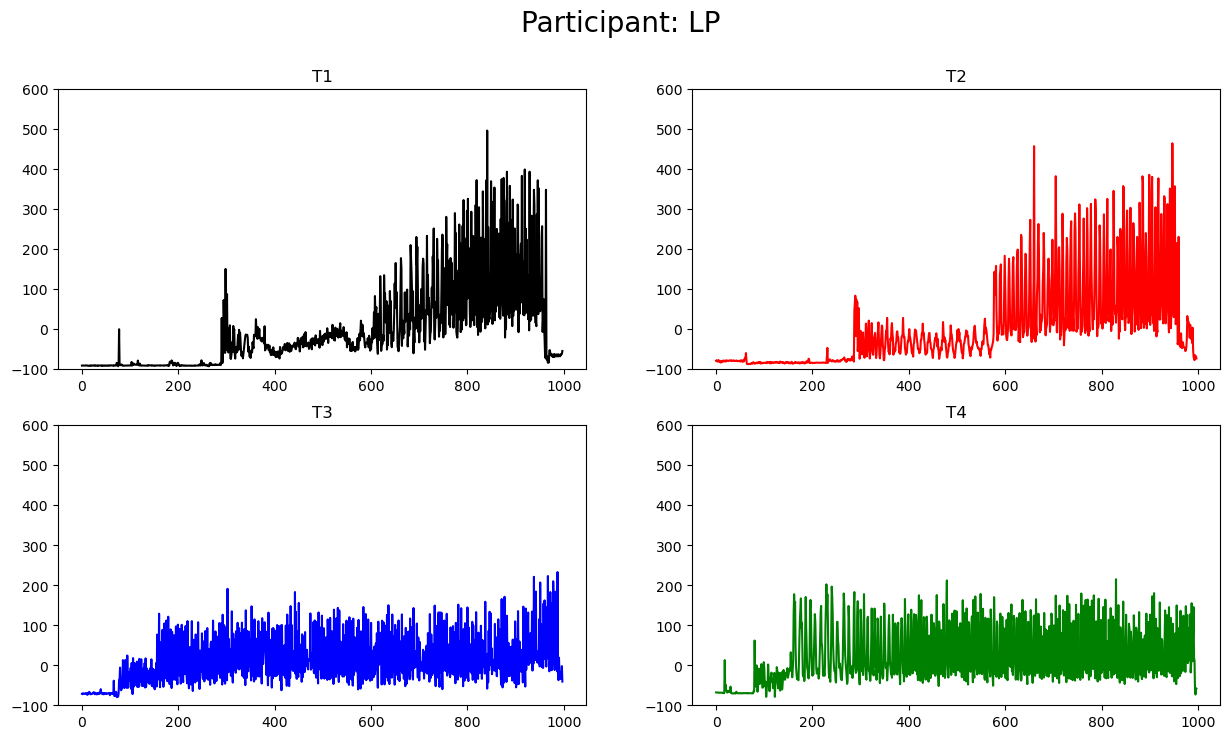

In [79]:
#for i in range(Array_Interpolated_Time_AllFiles_Mean.shape[0]):
#    plt.plot(Array_Interpolated_Time_AllFiles[0,:,1:],'k')
#    plt.plot(Array_Interpolated_Time_AllFiles[1,:,1:],'r')
    #plt.plot(Array_Interpolated_Time_AllFiles[2,:,1:],'b')
    #plt.plot(Array_Interpolated_Time_AllFiles[3,:,1:],'g')

fig, ax = plt.subplots(nrows=2, ncols=2,)
width = 15
height = 8
fig.set_size_inches(width,height) 
#for i in range(Array_Interpolated_Time_AllFiles_Mean.shape[0]):
ax[0,0].plot(Array_Interpolated_Time_AllFiles_Mean[0,2:],'k', label='T1')
ax[0,0].set_title('T1')
ax[0,1].plot(Array_Interpolated_Time_AllFiles_Mean[1,2:]+7,'r', label='T2')
ax[0,1].set_title('T2')
ax[1,0].plot(Array_Interpolated_Time_AllFiles_Mean[2,2:]+14,'b', label='T3')
ax[1,0].set_title('T3')
ax[1,1].plot(Array_Interpolated_Time_AllFiles_Mean[3,2:]+21,'g', label='T4')
ax[1,1].set_title('T4')

for ax in ax.flat:
    ax.set_ylim(-100, 600)
#fig.tick_params(labelsize=18)
#ax.legend(loc = 'upper left', frameon=False, fontsize=15)
#ax.set_ylabel('Muscular Activity (RMS)', fontsize=20)
#ax.set_xlabel("Time Normalized (1000 data points))", fontsize=20)
plt.suptitle('Participant: LP', fontsize=20)
    
    # Save the figure as a JPG file
output_figure =  "C:/Users/andre/Documents/Andre/Pesquisa/Projetos Pesquisa/Projeto Stefano/Routine/Data Test/FigureEMG.jpg"
plt.savefig(output_figure, dpi=300, format="jpg")
#plt.show()

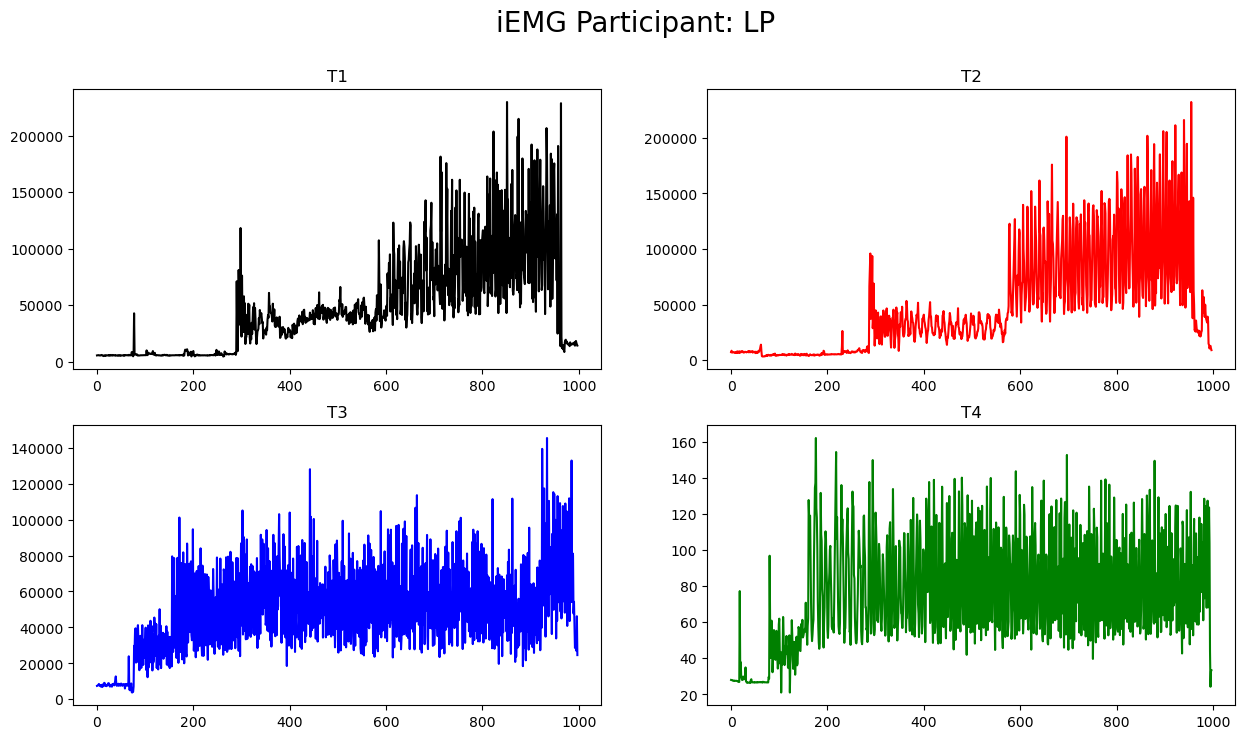

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=2,)
width = 15
height = 8
fig.set_size_inches(width,height) 
#for i in range(Array_Interpolated_Time_AllFiles_Mean.shape[0]):
ax[0,0].plot(Array_iEMG_Interpolated_Time_AllFiles_Mean[0,2:],'k', label='T1')
ax[0,0].set_title('T1')
ax[0,1].plot(Array_iEMG_Interpolated_Time_AllFiles_Mean[1,2:]+7,'r', label='T2')
ax[0,1].set_title('T2')
ax[1,0].plot(Array_iEMG_Interpolated_Time_AllFiles_Mean[2,2:]+14,'b', label='T3')
ax[1,0].set_title('T3')
ax[1,1].plot(Array_iEMG_Interpolated_Time_AllFiles_Mean[3,2:]+21,'g', label='T4')
ax[1,1].set_title('T4')

#for ax in ax.flat:
#    ax.set_ylim(-100, 600)

#fig.tick_params(labelsize=18)
#ax.legend(loc = 'upper left', frameon=False, fontsize=15)
#ax.set_ylabel('Muscular Activity (RMS)', fontsize=20)
#ax.set_xlabel("Time Normalized (1000 data points))", fontsize=20)
plt.suptitle('iEMG Participant: LP', fontsize=20)
    
    # Save the figure as a JPG file
output_figure =  "C:/Users/andre/Documents/Andre/Pesquisa/Projetos Pesquisa/Projeto Stefano/Routine/Data Test/FigureEMG_iEMG.jpg"
plt.savefig(output_figure, dpi=300, format="jpg")
#plt.show()